First we will import packages


In [121]:


import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import torch
import torch.nn as nn
from IPython import display
import random
import importlib
import NeuralNetUtils as nnu
importlib.reload(nnu)
from NeuralNetUtils import RawData, NeuralNetwork, DataSet
import math

%matplotlib inline


Setup the environment. We will train a model to play the Lunar-Lander-V2 environment from the gym library.

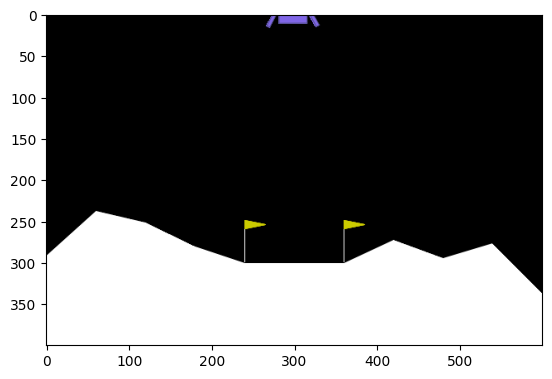

In [122]:
GAME_NAME = 'LunarLander-v3'
env = gym.make(GAME_NAME, render_mode='rgb_array')
state = env.reset()
fig, ax = plt.subplots()

def RenderFrame(env,envState=None,debugText = None):
    ax.clear()  # Clear the previous image
    arr = env.render()
    ax.imshow(arr)
    def DisplayData():
        if debugText is not None: ax.text(50,100,debugText, color="yellow")
        if envState is not None: ax.text(1,1,F"(X, Y): ({envState.x}, {envState.y})")
    DisplayData()
    display.display(fig)  # Display the figure object
    display.clear_output(wait=True)  # Clear the output for the next frame
    






RenderFrame(env)



Let's get an insight into our environment

In [123]:
def PrintEnvironmentSpecs(environmentName: str):
    env = gym.make(environmentName)
    spec = gym.spec(environmentName)
    print(f"Action Space: {env.action_space}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Nondeterministic: {spec.nondeterministic}")
    print(f"Reward Threshold: {spec.reward_threshold}")

PrintEnvironmentSpecs(GAME_NAME)

Action Space: Discrete(4)
Observation Space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Max Episode Steps: 1000
Nondeterministic: False
Reward Threshold: 200


Using this info, lets create a data object to store environment data in a more human-readable format

In [124]:
class EnvironmentState:
    def __init__(self,state):
        coord = state[0]
        self.x = coord[0]
        self.y = coord[1]
        self.x_dot = coord[2]
        self.y_dot = coord[3]
        self.theta = coord[4]
        self.theta_dot = coord[5]
        self.leftLegTouching = int(coord[6])
        self.rightLegTouching = int(coord[7])
        reward = 0
        isDone = False
        if len(state)>2:
            reward = state[1]
            isDone = state[2] or state[3]
        self.reward = reward
        self.isDone = isDone 
    
    def __repr__(self):
        lines = [
            f"(x, y): ({self.x}, {self.y})",
            f"(ẋ, ẏ): ({self.x_dot}, {self.y_dot})",
            f"θ: {self.theta}",
            f"dθ/dt: {self.theta_dot}",
            f"Legs touching (L,R): ({self.leftLegTouching}, {self.rightLegTouching})",
            f" Reward: {self.reward}",
            f" Done: {self.isDone}",
        ]
        return "\n".join(lines,)

    def toTensor(self) -> torch.Tensor:
        return nnu.convertToTensor(self.toArray().astype(np.float32))
    
    def toArray(self) -> np.array:
        return np.array(self.toList())
    
    def toList(self) -> List[float]:
        return [self.x, self.y, self.x_dot, self.y_dot, self.theta, self.theta_dot, self.leftLegTouching, self.rightLegTouching]

Lets take a look at the model's observation

In [125]:
print(state)
print(len(state))
envState = EnvironmentState(state)

print(envState)

(array([-0.00534134,  1.4018682 , -0.5410397 , -0.402322  ,  0.0061961 ,
        0.12255351,  0.        ,  0.        ], dtype=float32), {})
2
(x, y): (-0.00534133892506361, 1.401868224143982)
(ẋ, ẏ): (-0.5410397052764893, -0.402321994304657)
θ: 0.006196099799126387
dθ/dt: 0.1225535124540329
Legs touching (L,R): (0, 0)
 Reward: 0
 Done: False


And lets run a quick iteration of the game, watching the state to make sure everything is working well

In [126]:
playAnimation = False
if playAnimation:#Change to true/false to play/skip animation
    envState = EnvironmentState(env.reset())
    while not envState.isDone:
        envState = EnvironmentState(env.step(0))
        RenderFrame(env,envState)


Now we'll make a class for the model

In [127]:
  

class Model:

    def __init__(self, epsilon : float, gamma : float, network : NeuralNetwork):
        self.epsilon = epsilon
        self.network = network
        self.gamma = gamma
    
    def outputLength(self): return self.network.outputCount()

    def CalculateAllQ(self, state: EnvironmentState) -> List[float]: #returns estimated Q for each action possibility
        tensor = self.network.forward(state.toTensor())
        return nnu.convertToNumpy(tensor)
    
    def GetDecision(self, state: EnvironmentState) -> List[float]: #returns a list of all zeros except for a single 1 for the chosen decision
        allQ = self.CalculateAllQ(state)
        idx = np.argmax(allQ)

        rand = random.uniform(0,1)
        if rand < self.epsilon:
            idx = random.randint(0, len(allQ) - 1)

        action = np.zeros(len(allQ))
        action[idx] = 1
        return action.astype(np.float64)
    
    def convertData(self, data : List[RawData[EnvironmentState]]) -> DataSet:
        rowCount = len(data)
        firstRow = data[0].State
        firstRowPredictions = self.CalculateAllQ(firstRow)
        X = np.zeros((rowCount,len(firstRow.toList())))
        Y = np.zeros((rowCount,len(firstRowPredictions)))

        for (i,row) in  enumerate(data):
            state = row.State
            x = state.toArray()
            q = row.Reward
            if not state.isDone:
                qPrime = self.CalculateAllQ(row.NextState)
                q = self.gamma * qPrime + row.Reward
            
        X[i] = np.array(x, dtype=np.float32)  # Cast to float32
        Y[i] = np.array(q, dtype=np.float32)  # Cast to float32
        return DataSet.buildFromNumpy(X,Y)
    
    
    def Train(self, data : List[RawData], loss, trainingParams):
        dataSet = self.convertData(data)
        nnu.trainModel([dataSet],self.network,loss, trainingParams, False)
        


Now lets define a reward function based on the environment state

In [128]:
def Reward(state:EnvironmentState) -> float:
    reward = 0
    WINVALUE = 1000
    CRASHVALUE = -1000
    UPRIGHTVALUE = 1
    SPEEDVALUE = 100
    if state.reward > 0:
        reward += WINVALUE
    elif state.isDone:
        reward += CRASHVALUE
    
    theta = state.theta
    reward += -abs(theta)*UPRIGHTVALUE
    return reward

Lets define the training function

In [129]:

def GetTrainingDataBatch(model : Model, batchSize : int, env : gym.Env):
    data : List[RawData] = []
    gamesCompleted = 0
    state = EnvironmentState(env.step(0))
    for i in range(batchSize):
        reward = Reward(state)
        action = model.GetDecision(state)
        nextState =  EnvironmentState(env.step(np.argmax(action)))
        if nextState.isDone:
            gamesCompleted += 1
        dataPoint: RawData = RawData(state,action,reward,nextState)
        data.append(dataPoint)
        state = nextState

        if state is None or state.isDone:
            dataPoint: RawData = RawData(state,None,reward,None)
            data.append(dataPoint)
            state = EnvironmentState(env.reset())
    return (data)
    
def getAverageReward(data : List[RawData]) -> float:
    gamesPlayed = 0
    totalReward = 0
    for row in data:
        state = row.State
        if state.isDone:
            gamesPlayed += 1
        totalReward += Reward(state)
    if gamesPlayed == 0:
        return 0
    return totalReward / gamesPlayed


And train the model!

In [ ]:
BATCH_SIZE = 4

hiddenLayers = [1000,1000,1000,4]
layers = nnu.buildLayers(hiddenLayers)
inputFeatureCount = len(envState.toTensor())
network = NeuralNetwork(inputFeatureCount,layers)
model = Model(.5,.99,network)
trainingParams = nnu.TrainingParams() 
trainingParams.learningRate = 10
trainingParams.regularizationConstant = 1e-1
trainingParams.iterations = 60
loss = nn.CrossEntropyLoss()

print(network.shape())

EPISODES = 100
reward = np.zeros((EPISODES))
print(F"Running on {nnu.getDevice()}")
for i in range(EPISODES):
    data = GetTrainingDataBatch(model, BATCH_SIZE,env)
    model.Train(data,loss, trainingParams)
    reward[i] = getAverageReward(data)
    completion = i/EPISODES
    nnu.printLoadBar(completion)


[   8. 1000. 1000. 1000.    4.]
Running on NVIDIA GeForce GTX 1080


Let's plot the result!

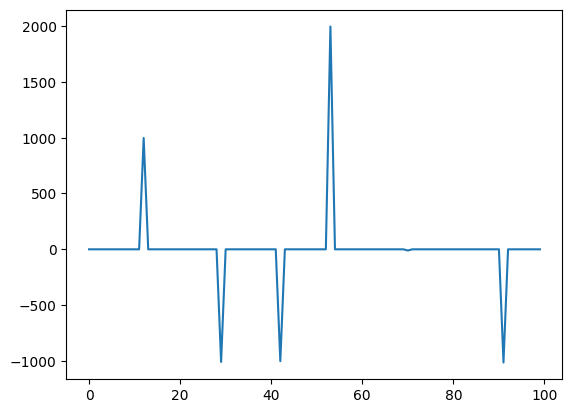

In [119]:
fig, ax = plt.subplots()
ax.clear()  # Clear the previous image
ax.plot(range(EPISODES),reward)

Let's watch the model fly!

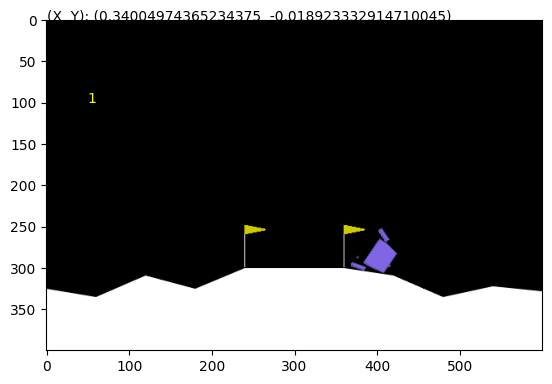

In [120]:
fig, ax = plt.subplots()

model.epsilon = 0

envState = EnvironmentState(env.reset())
while not envState.isDone:
    decision = model.GetDecision(envState)
    action = np.argmax(decision)    
    envState = EnvironmentState(env.step(action))
    RenderFrame(env,envState,action)